<a href="https://colab.research.google.com/github/theRoughCode/qml-top-quark/blob/notebook/top_quark_reuploading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data reuploading

In this sample notebook, we apply the data reuploading circuit proposed by [Pérez-Salinas et al. (2019)](https://arxiv.org/abs/1907.02085) to the 4 top quark dataset.

<p align="center">
  <img src="https://pennylane.ai/qml/_images/universal_dnn.png" width="50%" />
</p>

[Image source](https://pennylane.ai/qml/demos/tutorial_data_reuploading_classifier.html)

## Background
The Standard Model predicts the production of 4 top quarks from proton-proton interactions at the centre-of-mass energy of √s = 13 TeV. Our goal is to apply using the data reuploading variational quantum circuit to identify the 4 top quark signal against competing tt ̄ + jets background.



## Install dependencies

In [1]:
!pip install -q tensorflow==2.4.1
!pip install -q -U tensorflow-quantum

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq

from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import os
import cirq
import math
import sympy
import collections
import numpy as np
import pandas as pd

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## Download dataset

We will be using the 4 top quark dataset produced using Monte-Carlo simulations. For this sample notebook, we will only be using 5000 samples.

Each sample has 76 features and the last column represents its type (signal=1 or background=0).

In [3]:
df = pd.read_pickle("https://drive.google.com/uc?export=download&id=18VGtTeI4EEki5l8dz1Bloyz_toDPnTGl")
df

,b'AK4HTpMETpLepPt',b'minMleppBjet',b'mass_minBBdr',b'deltaR_lepBJet_maxpt',b'lepDR_minBBdr',b'centrality',b'deltaEta_maxBB',b'aveCSVpt',b'aveBBdr',b'FW_momentum_0',b'FW_momentum_1',b'FW_momentum_2',b'FW_momentum_3',b'FW_momentum_4',b'FW_momentum_5',b'FW_momentum_6',b'mass_maxJJJpt',b'BJetLeadPt',b'deltaR_minBB',b'minDR_lepBJet',b'MT_lepMet',b'AK4HT',b'hemiout',b'theJetLeadPt',b'corr_met_MultiLepCalc',b'leptonPt_MultiLepCalc',b'mass_lepJets0',b'mass_lepJets1',b'mass_lepJets2',b'MT2bb',b'mass_lepBJet0',b'mass_lepBJet_mindr',b'secondJetPt',b'fifthJetPt',b'sixthJetPt',b'PtFifthJet',b'mass_minLLdr',b'mass_maxBBmass',b'deltaR_lepJetInMinMljet',b'deltaPhi_lepJetInMinMljet',b'deltaR_lepbJetInMinMlb',b'deltaPhi_lepbJetInMinMlb',b'M_allJet_W',b'HT_bjets',b'ratio_HTdHT4leadjets',b'csvJet3',b'csvJet4',b'firstcsvb_bb',b'secondcsvb_bb',b'thirdcsvb_bb',b'fourthcsvb_bb',b'NJets_JetSubCalc',b'HT_2m',b'Sphericity',b'Aplanarity',b'minDR_lepJet',b'BDTtrijet1',b'BDTtrijet2',b'BDTtrijet3',b'BDTtrijet4',b'NresolvedTops1pFake',b'NJetsTtagged',b'NJetsWtagged',b'NJetsCSV_MultiLepCalc',b'HOTGoodTrijet1_mass',b'HOTGoodTrijet1_dijetmass',b'HOTGoodTrijet1_pTratio',b'HOTGoodTrijet1_dRtridijet',b'HOTGoodTrijet1_csvJetnotdijet',b'HOTGoodTrijet1_dRtrijetJetnotdijet',b'HOTGoodTrijet2_mass',b'HOTGoodTrijet2_dijetmass',b'HOTGoodTrijet2_pTratio',b'HOTGoodTrijet2_dRtridijet',b'HOTGoodTrijet2_csvJetnotdijet',b'HOTGoodTrijet2_dRtrijetJetnotdijet',b'type'
1177704,682.735352,58.657413,114.053337,0.874831,2.644135,0.531955,2.692158,0.875101,2.551161,1.0,0.042984,0.130096,0.170135,0.104594,0.147318,0.208072,245.860123,122.798317,1.191257,0.874831,113.619827,535.387390,391.182739,122.798317,102.682815,44.665131,195.381607,58.657410,121.286308,16.062830,195.381607,58.657410,102.480225,44.821953,40.567646,74.851082,32.061378,304.910217,0.874831,0.872951,0.874831,0.872951,1020.055969,344.839203,1.428201,0.057417,0.779953,0.997286,0.922355,0.805651,0.779953,8.0,310.108856,0.414893,0.112494,0.874831,0.733111,0.722380,0.234663,-1.0,0.0,0.0,0.0,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1277853,1000.195374,120.986732,72.012695,0.760806,2.944085,0.429811,-0.595313,0.642168,2.002609,1.0,0.016375,0.329226,0.179324,0.186082,0.158154,0.257468,307.330597,176.256210,0.848851,0.760806,120.715942,817.905090,659.292908,192.766205,36.683549,145.606735,554.525452,120.986725,244.762375,44.169163,120.986725,120.986725,176.256210,79.435555,67.184006,82.982498,70.856010,274.349365,0.760806,0.760805,0.760806,0.760805,2038.136963,342.021057,1.485518,0.688826,0.021674,0.892226,0.688826,0.515083,0.053752,8.0,543.068054,0.124995,0.008856,0.760806,0.775929,0.625265,0.003489,-1.0,0.0,0.0,0.0,3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145952,738.931213,85.254593,66.675728,2.677009,2.495218,0.495702,0.731196,0.809622,1.493621,1.0,0.300271,0.175520,0.138221,0.188542,0.214255,0.141195,252.534256,91.264847,0.906897,2.242874,98.362679,619.673584,299.442963,174.286545,80.747887,38.509727,89.783348,138.630814,116.809769,10.703771,116.809769,85.743156,117.486404,53.420841,51.667206,117.486404,74.400154,105.948257,2.256722,2.140476,2.256722,2.140476,1027.889648,196.352890,1.307152,0.963986,0.040017,0.963986,0.789684,0.538216,0.463565,7.0,474.987885,0.228929,0.054426,1.037779,0.966624,0.048576,-1.000000,-1.0,1.0,0.0,1.0,3.0,165.450943,123.999466,0.795916,0.192122,-2.000000,1.771105,0.0,0.0,0.0,0.0,0.0,0.0,1.0
53830,1480.729614,115.734131,100.512062,2.797322,1.380733,0.661050,-1.178474,0.825314,2.213313,1.0,0.165260,0.080320,0.107420,0.177591,0.195637,0.071353,522.247864,296.823364,1.135289,1.129829,74.113297,1239.098267,697.314209,296.823364,111.693557,129.937759,474.568085,391.458374,374.514923,41.415146,474.568085,115.734131,207.194229,135.423798,85.489708,198.872818,67.046616,376.245514,1.129829,-1.113645,1.129829,-1.113645,2148.966553,459.615723,1.443371,0.044708,0.034917,0.978338,0.832147,0.651525,0.119132,9.0,856.785217,

### Variable importance ranking
In previous work, Narain et al. ranked the 76 variables according to their relative importance to the performance of a DNN (Dense Neural Network).

In this notebook, we will pick the top 3 variables and use them in our classification task.

In [4]:
NUM_VARS = 3

nJ4_2017_top_30_variables = pd.read_csv("https://drive.google.com/uc?export=download&id=1d8FgsKW1HpCEloqvxmIqHRtBUwBpjCV5")
nJ4_2017_top_30_variables = nJ4_2017_top_30_variables.columns.values.tolist()
top_n_variables = nJ4_2017_top_30_variables[:NUM_VARS]
# Encode strings into bytes to be compatible with df column names
top_n_variables = [str.encode(s) for s in top_n_variables]
top_n_variables

[b'thirdcsvb_bb', b'MT_lepMet', b'fourthcsvb_bb']

In [5]:
# Filter out top NUM_VARS columns and convert to numpy array
ds_x = df[top_n_variables].to_numpy()
ds_y = df[b"type"].to_numpy()

## Preprocessing

The data values have a wide range. Scaling and normalizing the input data can aid in training performance and stability.

Let's see the range of data values we're dealing with.

In [6]:
np.min(ds_x), np.max(ds_x)

(-2.0, 732.0361938476562)

To normalize the data, we pass them through 2 preprocessors:
1. StandardScaler: standardize features by removing the mean and scaling to unit variance
2. MinMaxScaler: scale and translate data to be in the range `[-1, 1]`

In [7]:
preprocessors = [StandardScaler(), MinMaxScaler((-1, 1))]

for preprocessor in preprocessors:
  ds_x = preprocessor.fit_transform(ds_x)

Finally, we split the dataset up into training, test, and validation sets in the ratio 80/10/10, respectively.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(ds_x, ds_y, test_size=0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=len(x_test))

## Building our Quantum model
In this section, we build our data reuploading model using Tensorflow Quantum.

First, let's define a helper function that performs an arbitrary single-qubit rotation on a given qubit. In the Tensorflow Quantum framework, we construct quantum circuits using [Cirq](https://quantumai.google/cirq).

This function takes in a qubit and 3 angles, and performs an RX, RY, and RZ rotation.

In [9]:
def one_qubit_unitary(bit, inputs):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `inputs`.
    Bit: 1
    Inputs: 3
    """
    return cirq.Circuit(
        cirq.X(bit) ** inputs[0],
        cirq.Y(bit) ** inputs[1],
        cirq.Z(bit) ** inputs[2],
    )

Now, we define the data reuploading circuit as a Tensorflow `Layer`:

In [10]:
class ReuploadingCircuit(tf.keras.layers.Layer):
  def __init__(self, input_dims, num_qubits, num_layers, name='re-uploading_circuit'):
    super(ReuploadingCircuit, self).__init__()
    self.num_qubits = num_qubits
    self.num_layers = num_layers

    # Encode inputs in groups of 3
    self.num_encoding_blocks = math.ceil(input_dims / 3) 
    self.num_params = self.num_encoding_blocks * 3

    weights_init = tf.random_uniform_initializer(minval=-1.0, maxval=1.0)
    self.num_weights = self.num_qubits * self.num_layers * 3
    self.thetas = tf.Variable(
        initial_value=weights_init(shape=(1, self.num_weights), dtype='float32'),
        trainable=True,
        name='thetas')
    self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])

    self.pqc = self.build_model()
    
  def build_model(self):
    qubits = cirq.GridQubit.rect(1, self.num_qubits)
    readouts = [cirq.Z(qubits[-1])]

    # Sympy symbols for encoding inputs
    encoding_params = sympy.symbols(f'x_0:{self.num_encoding_blocks * 3}')
    encoding_params = np.asarray(encoding_params).reshape((self.num_encoding_blocks, 3))

    # Sympy symbols for trainable parameters
    trainable_params = sympy.symbols(f'θ_0:{self.num_weights}')
    trainable_params = np.asarray(trainable_params).reshape((self.num_layers, self.num_qubits, 3))

    # Define explicit symbol order to follow the alphabetical order of their symbol names,
    # as processed by the ControlledPQC.
    symbols = [str(symb) for symb in list(encoding_params.flat) + list(trainable_params.flat)]
    self.indices = tf.constant([sorted(symbols).index(a) for a in symbols])

    # Create circuit
    circuit = cirq.Circuit()
    for l in range(self.num_layers):
      # Encoding layer
      for q in qubits:
        circuit += cirq.Circuit(one_qubit_unitary(q, encoding_params[b]) for b in range(self.num_encoding_blocks))

      # Variational layer
      circuit += cirq.Circuit(one_qubit_unitary(q, trainable_params[l, i]) for i, q in enumerate(qubits))

      # Entangling layer
      if self.num_qubits > 1:
        if l < self.num_layers - 1:
          # entangle qubits if not last layer
          circuit += [cirq.CZ(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]

    print(circuit)

    pqc = tfq.layers.ControlledPQC(circuit, readouts)

    return pqc

  def call(self, inputs):
    batch_size = tf.shape(inputs)[0]

    # Duplicate thetas across batch
    thetas = tf.tile(self.thetas, multiples=[batch_size, 1], name='tile_weights')

    # Pad tensors if necessary
    num_padding = self.num_params - inputs.shape[1]
    if num_padding != 0:
      inputs = tf.pad(inputs, tf.constant([[0, 0,], [0, num_padding]]), name='pad_inputs')

    # Flatten inputs
    flattened = tf.keras.layers.Flatten(name='flatten')(inputs)

    circuits = tf.repeat(self.empty_circuit, repeats=batch_size, name='tile_circuits')
    model_params = tf.concat([flattened, thetas], axis=-1, name='concat_model_params')
    model_params = tf.gather(model_params, self.indices, axis=-1, name='permute_model_params')

    return self.pqc([circuits, model_params])

Finally, we wrap our reuploading layer into a Tensorflow `Model`. Note that the `ReuploadingCircuit` layer outputs values in the range `[-1, 1]`, corresponding to the expectation values of the Pauli Z measurement. We allow optionally adding a classical classification head.

In [11]:
def build_reuploading_model(num_qubits, num_layers, use_classical=False):
  inputs = tf.keras.Input(shape=(NUM_VARS,), dtype=tf.dtypes.float32)
  x = ReuploadingCircuit(NUM_VARS, num_qubits, num_layers)(inputs)

  if use_classical:
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  else:
    out = (x + 1.) / 2.

  model = tf.keras.Model(inputs=inputs, outputs=out)

  return model

Let's construct a reuploading circuit of a single qubit and 6 layers, with a classical classification head.

In [12]:
BATCH_SIZE = 64

model = build_reuploading_model(1, 6, True)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3), metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc')])
model.summary()

(0, 0): ───X^x_0───Y^x_1───Z^x_2───X^(θ_0)───Y^(θ_1)───Z^(θ_2)───X^x_0───Y^x_1───Z^x_2───X^(θ_3)───Y^(θ_4)───Z^(θ_5)───X^x_0───Y^x_1───Z^x_2───X^(θ_6)───Y^(θ_7)───Z^(θ_8)───X^x_0───Y^x_1───Z^x_2───X^(θ_9)───Y^(θ_10)───Z^(θ_11)───X^x_0───Y^x_1───Z^x_2───X^(θ_12)───Y^(θ_13)───Z^(θ_14)───X^x_0───Y^x_1───Z^x_2───X^(θ_15)───Y^(θ_16)───Z^(θ_17)───
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
reuploading_circuit (Reuploa (None, 1)                 18        
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


## Training

Before training our model, we convert our datasets into Tensorflow `Dataset`s and batch them.

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE, drop_remainder=True)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE, drop_remainder=True)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE, drop_remainder=True)

Let's start training!

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = model.fit(train_ds,
        batch_size=BATCH_SIZE,
        epochs=20,
        verbose=1,
        validation_data=val_ds,
        callbacks=[callback])

Epoch 1/20
62/62 [==============================] - 5s 72ms/step - loss: 0.6340 - binary_accuracy: 0.6682 - auc: 0.7052 - val_loss: 0.5977 - val_binary_accuracy: 0.7254 - val_auc: 0.7746
Epoch 2/20
62/62 [==============================] - 4s 67ms/step - loss: 0.6134 - binary_accuracy: 0.6971 - auc: 0.7401 - val_loss: 0.5877 - val_binary_accuracy: 0.7388 - val_auc: 0.7813
Epoch 3/20
62/62 [==============================] - 4s 65ms/step - loss: 0.6058 - binary_accuracy: 0.7039 - auc: 0.7448 - val_loss: 0.5790 - val_binary_accuracy: 0.7478 - val_auc: 0.7900
Epoch 4/20
62/62 [==============================] - 4s 66ms/step - loss: 0.5987 - binary_accuracy: 0.7100 - auc: 0.7511 - val_loss: 0.5711 - val_binary_accuracy: 0.7478 - val_auc: 0.7980
Epoch 5/20
62/62 [==============================] - 4s 66ms/step - loss: 0.5919 - binary_accuracy: 0.7158 - auc: 0.7580 - val_loss: 0.5641 - val_binary_accuracy: 0.7478 - val_auc: 0.8027
Epoch 6/20
62/62 [==============================] - 4s 67ms/step 

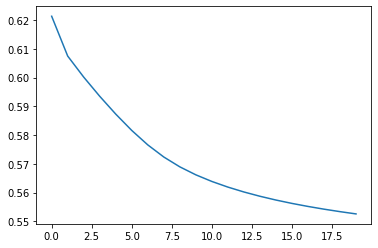

In [15]:
plt.plot(history.history['loss'])

Let's see how our trained model does on our test dataset:

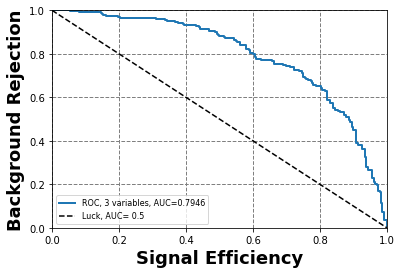

In [16]:
y_score = model.predict(test_ds)
# We need to trim `y_test`z to account for dropped samples when batching `test_ds`
y_true = y_test[:len(y_score)]

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(tpr, 1 - fpr, label="ROC, {} variables, AUC={:.4f}".format(NUM_VARS, roc_auc), linewidth=2)
plt.xlabel("Signal Efficiency", fontsize=18, fontweight='bold')
plt.ylabel("Background Rejection", fontsize=18, fontweight='bold')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.grid(color='gray', linestyle='--', linewidth=1) 
plt.plot([0, 1], [1, 0], linestyle='--', color='black', label='Luck, AUC= 0.5')
plt.legend(loc='best',prop={'size': 8})

## Varying number of qubits and layers
Let's see how our model performs as we vary the number of qubits and layers.

In [17]:
models = [
  build_reuploading_model(1, 6, BATCH_SIZE),
  build_reuploading_model(2, 3, BATCH_SIZE),
  build_reuploading_model(3, 2, BATCH_SIZE),
  build_reuploading_model(6, 1, BATCH_SIZE),
]
for model in models:
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3), metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc')])

(0, 0): ───X^x_0───Y^x_1───Z^x_2───X^(θ_0)───Y^(θ_1)───Z^(θ_2)───X^x_0───Y^x_1───Z^x_2───X^(θ_3)───Y^(θ_4)───Z^(θ_5)───X^x_0───Y^x_1───Z^x_2───X^(θ_6)───Y^(θ_7)───Z^(θ_8)───X^x_0───Y^x_1───Z^x_2───X^(θ_9)───Y^(θ_10)───Z^(θ_11)───X^x_0───Y^x_1───Z^x_2───X^(θ_12)───Y^(θ_13)───Z^(θ_14)───X^x_0───Y^x_1───Z^x_2───X^(θ_15)───Y^(θ_16)───Z^(θ_17)───
(0, 0): ───X^x_0───Y^x_1───Z^x_2───────────────────────────X^(θ_0)───Y^(θ_1)───Z^(θ_2)─────────────────────────────────@───X^x_0───Y^x_1───Z^x_2───────────────────────────X^(θ_6)───Y^(θ_7)───Z^(θ_8)───────────────────────────────────@───X^x_0───Y^x_1───Z^x_2───────────────────────────X^(θ_12)───Y^(θ_13)───Z^(θ_14)────────────────────────────────────
                                                                                                                       │                                                                                                                 │
(0, 1): ───────────────────────────X^x_0───Y^x_1───Z^x_2─────────────

These parameters were chosen specifically so that the number of trainable parameters in the models are the same. We see below that they all have 20 parameters.

In [18]:
for model in models:
  print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
reuploading_circuit_1 (Reupl (None, 1)                 18        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
reuploading_circuit_2 (Reupl (None, 1)                 18        
_________________________________________

In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the models
for i, model in enumerate(models):
  model.fit(train_ds,
        batch_size=BATCH_SIZE,
        epochs=20,
        verbose=1,
        validation_data=val_ds,
        callbacks=[callback])

Epoch 1/20
62/62 [==============================] - 6s 76ms/step - loss: 0.6810 - binary_accuracy: 0.5848 - auc: 0.6042 - val_loss: 0.6661 - val_binary_accuracy: 0.6183 - val_auc: 0.6291
Epoch 2/20
62/62 [==============================] - 4s 71ms/step - loss: 0.6541 - binary_accuracy: 0.6157 - auc: 0.6619 - val_loss: 0.6413 - val_binary_accuracy: 0.6384 - val_auc: 0.6838
Epoch 3/20
62/62 [==============================] - 5s 73ms/step - loss: 0.6375 - binary_accuracy: 0.6493 - auc: 0.6993 - val_loss: 0.6221 - val_binary_accuracy: 0.6741 - val_auc: 0.7194
Epoch 4/20
62/62 [==============================] - 4s 71ms/step - loss: 0.6244 - binary_accuracy: 0.6655 - auc: 0.7233 - val_loss: 0.6074 - val_binary_accuracy: 0.6830 - val_auc: 0.7445
Epoch 5/20
62/62 [==============================] - 4s 71ms/step - loss: 0.6137 - binary_accuracy: 0.6808 - auc: 0.7390 - val_loss: 0.5956 - val_binary_accuracy: 0.7121 - val_auc: 0.7599
Epoch 6/20
62/62 [==============================] - 4s 71ms/step 

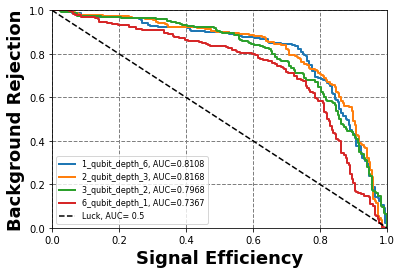

In [20]:
# Plot the roc curves
fpr_list, tpr_list = [], []

for i, model in enumerate(models):
    y_score = model.predict(val_ds)
    y_true = y_val[:len(y_score)]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    fpr_list.append(fpr)
    tpr_list.append(tpr)

labels = ['1_qubit_depth_6',
          '2_qubit_depth_3',
          '3_qubit_depth_2',
          '6_qubit_depth_1']

for fpr, tpr, label in zip(fpr_list, tpr_list, labels):
  roc_auc = auc(fpr, tpr)
  label += ', AUC={:.4f}'.format(roc_auc)
  plt.plot(tpr, 1 - fpr, linestyle='-', label=label, linewidth=2)

plt.xlabel("Signal Efficiency", fontsize=18, fontweight='bold')
plt.ylabel("Background Rejection", fontsize=18, fontweight='bold')
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.grid(color='gray', linestyle='--', linewidth=1) 
plt.plot([0, 1], [1, 0], linestyle='--', color='black', label='Luck, AUC= 0.5')
plt.legend(loc='best',prop={'size': 8})